In [131]:
import torch
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
from torchview import draw_graph

# !pip install transformers
from transformers import MobileNetV1Config, MobileNetV1Model

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [132]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [133]:
# collect directory

data_asli = Path('../data_')

In [134]:
# Melakukan pembagian data latih, validasi, dan uji dengan rasio perbandingan 70:15:15
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

data_dir = os.path.join(data_asli, 'gambar')
images_dir = os.path.join(data_dir, 'class')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'validasi')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

classes = os.listdir(images_dir)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    images = os.listdir(class_dir)

    n_total = len(images)    
    n_train = int(n_total * TRAIN_RATIO)
    n_val = int(n_total * VAL_RATIO)
    n_test = n_total - n_train - n_val 

    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(val_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in val_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(val_dir, c, image) 
        shutil.copyfile(image_src, image_dst)        
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)


In [135]:
train_data = datasets.ImageFolder(train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6945, 0.6518, 0.6161])
Calculated stds: tensor([0.1788, 0.2055, 0.2268])


In [136]:
pretrained_size = 224
pretrained_means = [0.6945, 0.6518, 0.6161]
pretrained_stds= [0.1788, 0.2055, 0.2268]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [137]:
train_data = datasets.ImageFolder(train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(test_dir, 
                                 transform = test_transforms)

valid_data = datasets.ImageFolder(val_dir, 
                                 transform = test_transforms)

In [138]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 350
Number of validation examples: 74
Number of testing examples: 76


In [139]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [140]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image  

In [141]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

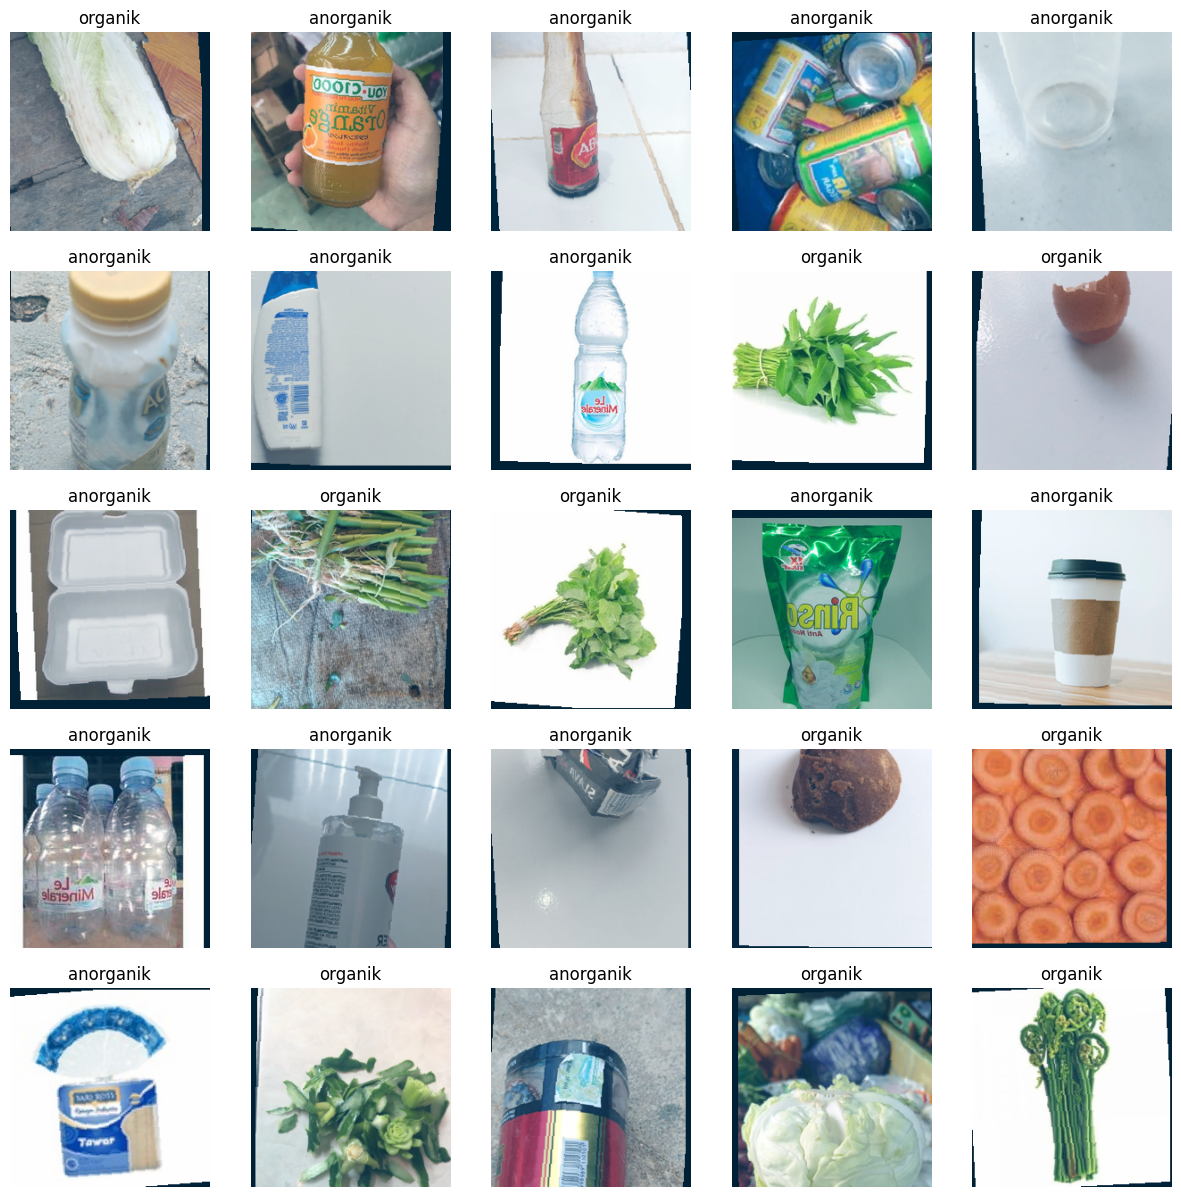

In [142]:
N_IMAGES = 25

random_ = random.sample(range(len(train_data)), N_IMAGES)

images, labels = zip(*[(train_data[i][0], train_data[i][1]) for i in random_])

classes = train_data.classes

plot_images(images, labels, classes)

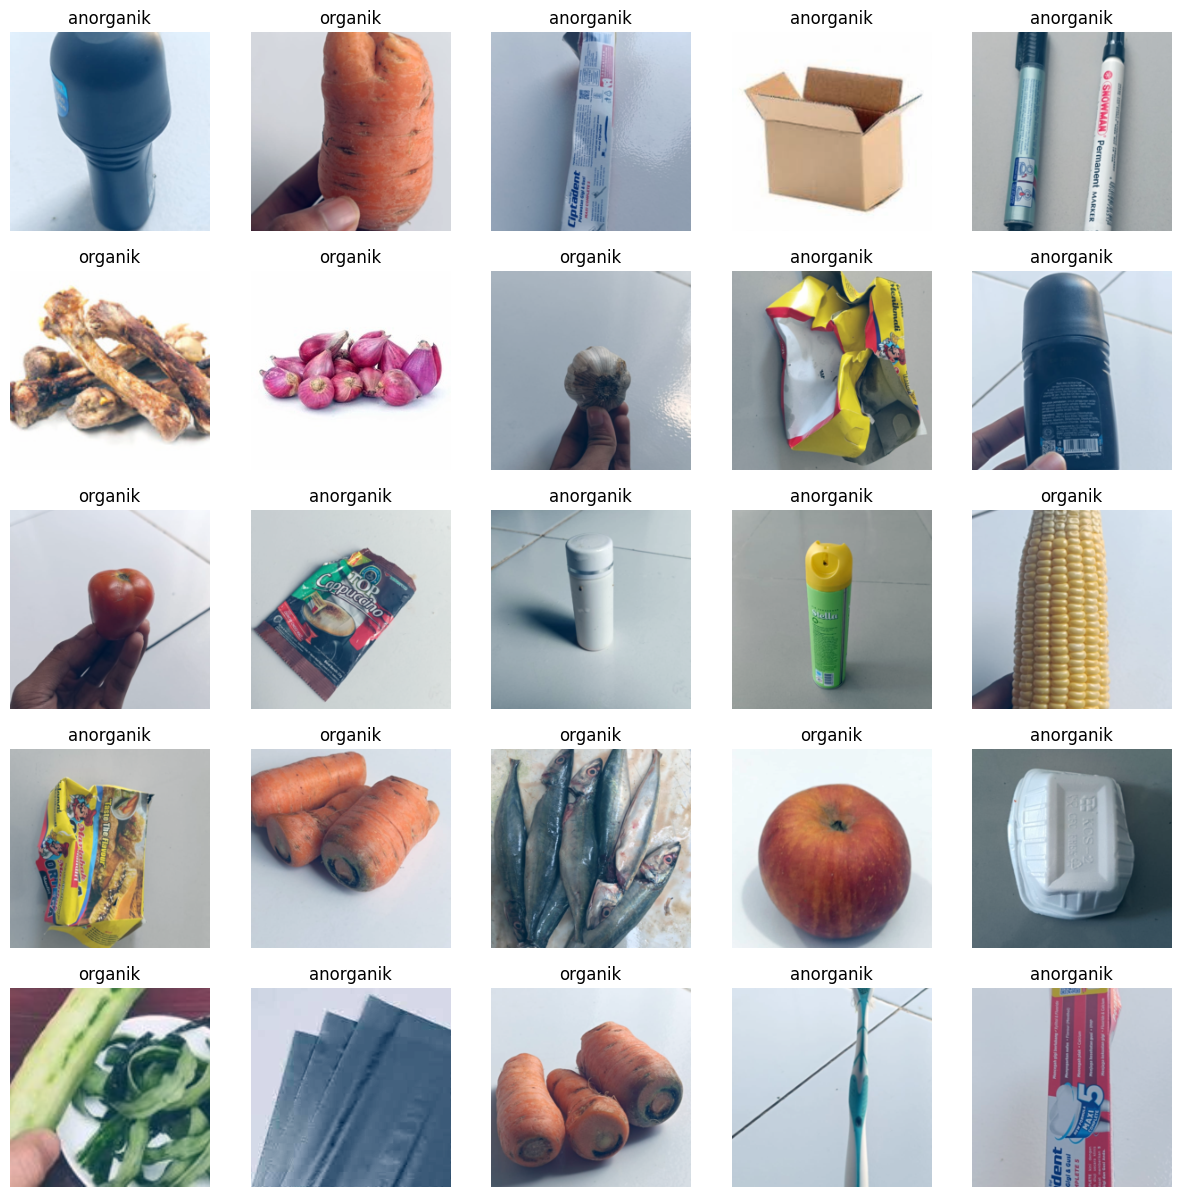

In [143]:
N_IMAGES = 25

random_ = random.sample(range(len(valid_data)), N_IMAGES)

images, labels = zip(*[(valid_data[i][0], valid_data[i][1]) for i in random_])

classes = valid_data.classes

plot_images(images, labels, classes)

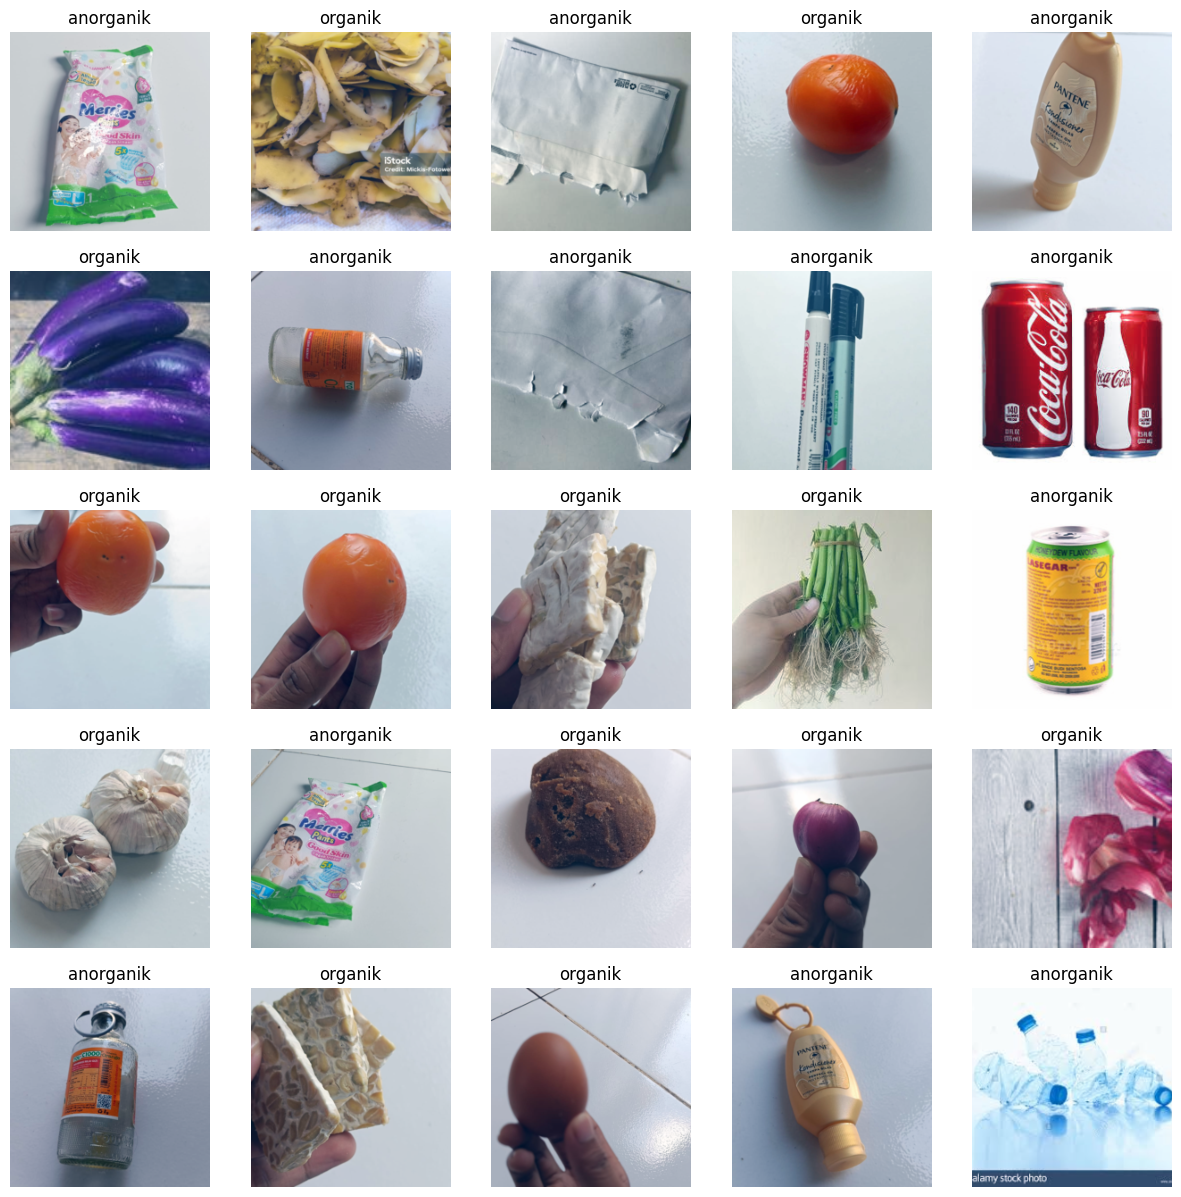

In [144]:
N_IMAGES = 25

random_ = random.sample(range(len(test_data)), N_IMAGES)

images, labels = zip(*[(test_data[i][0], test_data[i][1]) for i in random_])

classes = test_data.classes

plot_images(images, labels, classes)

In [145]:
class DepthWiseSeperable(nn.Module):

    def __init__(self, in_channels , out_channels , stride ):

        super(DepthWiseSeperable,self).__init__()
        
        # groups used here
        self.depthwise = nn.Conv2d(in_channels = in_channels , out_channels = in_channels ,
                                    stride = stride ,  padding = 1, kernel_size = 3 , 
                                    groups=in_channels , bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(in_channels = in_channels , out_channels = out_channels ,    
                                   stride = 1 , padding = 0, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self,x):

        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x



In [146]:
class MobileNetV1(nn.Module): 
    def __init__(self, output_dim): 
        super(MobileNetV1, self).__init__()
        # Initial convolution layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )
        # Depthwise separable convolutions
        self.features = nn.Sequential(
            self.features,
            DepthWiseSeperable(32, 64, 1),
            DepthWiseSeperable(64, 128, 2),
            DepthWiseSeperable(128, 128, 1),
            DepthWiseSeperable(128, 256, 2),
            DepthWiseSeperable(256, 256, 1),
            DepthWiseSeperable(256, 512, 2),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 1024, 2),
            DepthWiseSeperable(1024, 1024, 1)

        )
        
        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [147]:
OUTPUT_DIM = len(test_data.classes)

model_1 = MobileNetV1(OUTPUT_DIM)

In [148]:
print(model_1)

MobileNetV1(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthWiseSeperable(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): DepthWiseSeperable(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1

In [149]:
def count_parameters(model_1):
    return sum(p.numel() for p in model_1.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_1):,} trainable parameters')

The model has 3,209,026 trainable parameters


In [150]:
START_LR = 1e-7

optimizer = optim.Adam(model_1.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model_1.to(device)
criterion = criterion.to(device)

In [151]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), '../model_final/parameter_modelnet.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th = 5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('../model_final/parameter_modelnet.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [152]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [153]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

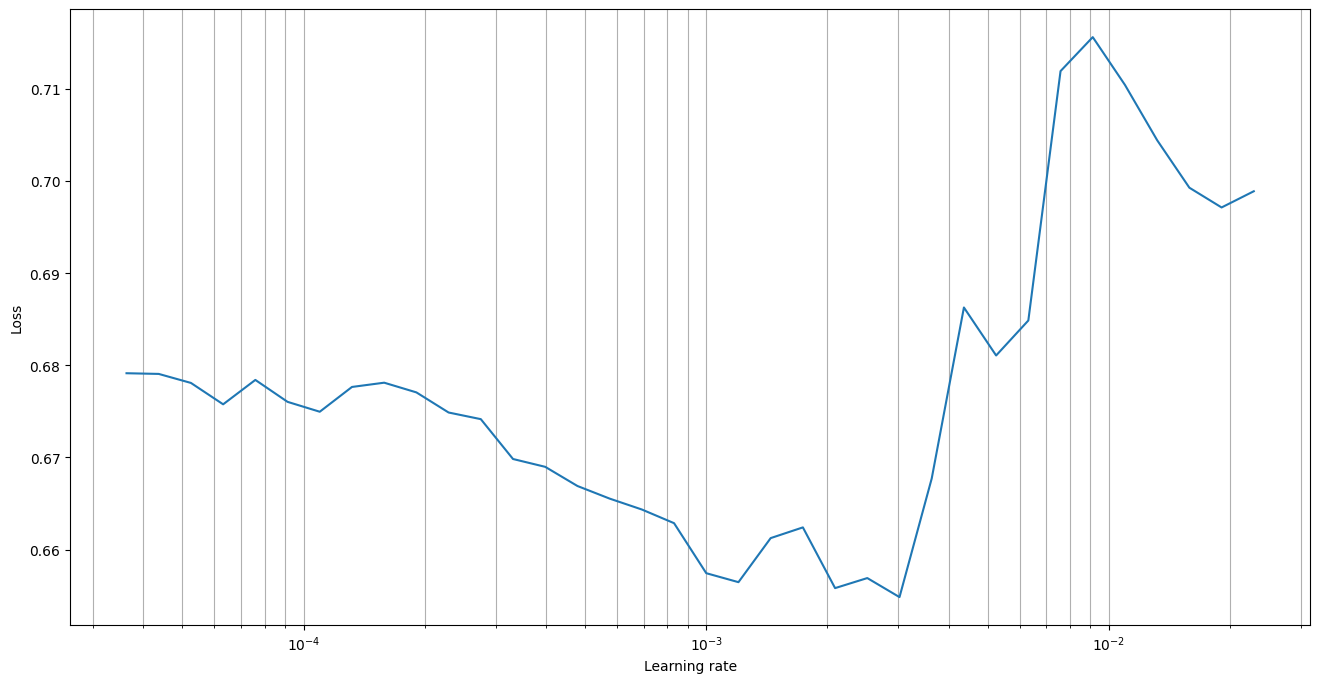

In [154]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [155]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model_1.parameters(), lr = FOUND_LR)

In [156]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [157]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        corrects = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        acc = corrects / batch_size
        
    return acc

In [158]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc = 0
    

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
   

    return epoch_loss, epoch_acc

In [159]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
   

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_topk_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
           

    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)


    return epoch_loss, epoch_acc

In [160]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [161]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../model_final/modelnetv1.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% ')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}% ')

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.671 | Train Acc :  57.97% 
	Valid Loss: 0.672 | Valid Acc :  61.46% 
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.651 | Train Acc :  59.64% 
	Valid Loss: 0.667 | Valid Acc :  61.46% 
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.658 | Train Acc :  57.42% 
	Valid Loss: 0.706 | Valid Acc :  38.54% 
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.640 | Train Acc :  64.26% 
	Valid Loss: 1.000 | Valid Acc :  38.54% 
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.616 | Train Acc :  63.66% 
	Valid Loss: 0.992 | Valid Acc :  46.88% 
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.565 | Train Acc :  69.15% 
	Valid Loss: 0.777 | Valid Acc :  57.29% 
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.504 | Train Acc :  74.60% 
	Valid Loss: 0.752 | Valid Acc :  69.38% 
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.477 | Train Acc :  79.20% 
	Valid Loss: 1.602 | Valid Acc :  54.79% 
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.503 | Train Acc :  75.17% 
	Valid Loss: 0.4

In [162]:
model.load_state_dict(torch.load('../model_final/modelnetv1.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')

Test Loss: 0.560 | Test Acc:  84.38%


In [163]:
model.load_state_dict(torch.load('../model_final/modelnetv1.pt'))

valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')

Valid Loss: 0.190 | Valid Acc:  88.33%


In [164]:
model.load_state_dict(torch.load('../model_final/modelnetv1.pt'))

train_loss, train_acc = evaluate(model, train_iterator, criterion, device)

print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')

Train Loss: 0.121 | Train Acc:  95.70%


In [165]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [166]:
images, labels, probs = get_predictions(model, test_iterator)

In [167]:
pred_labels = torch.argmax(probs, 1)

In [168]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (5, 5));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

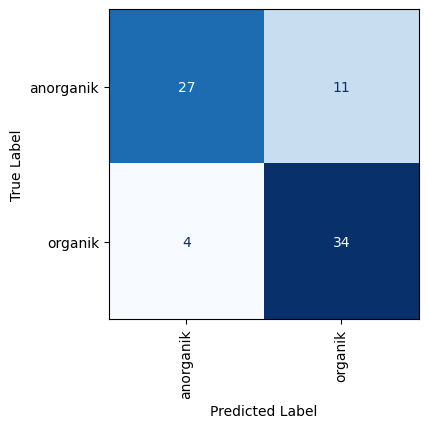

In [169]:
plot_confusion_matrix(labels, pred_labels, classes)

In [170]:
corrects = torch.eq(labels, pred_labels)

In [171]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [172]:


#fungsi untuk melihat probabilitas dari yang terrendah hingga tertinggi dari gambar yang diuji
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(key=lambda x: torch.max(x[2], dim=0).values.item())

for i, (image, label, prob) in enumerate(correct_examples):
    max_prob = torch.max(prob, dim=0).values.item()
    print(f"Image {i}: Label = {label}, Max Probability = {max_prob:.3f}")


Image 0: Label = 0, Max Probability = 0.594
Image 1: Label = 0, Max Probability = 0.683
Image 2: Label = 0, Max Probability = 0.690
Image 3: Label = 0, Max Probability = 0.842
Image 4: Label = 1, Max Probability = 0.846
Image 5: Label = 0, Max Probability = 0.853
Image 6: Label = 0, Max Probability = 0.875
Image 7: Label = 0, Max Probability = 0.876
Image 8: Label = 0, Max Probability = 0.901
Image 9: Label = 0, Max Probability = 0.903
Image 10: Label = 0, Max Probability = 0.906
Image 11: Label = 1, Max Probability = 0.911
Image 12: Label = 0, Max Probability = 0.934
Image 13: Label = 1, Max Probability = 0.939
Image 14: Label = 1, Max Probability = 0.943
Image 15: Label = 1, Max Probability = 0.953
Image 16: Label = 0, Max Probability = 0.955
Image 17: Label = 1, Max Probability = 0.958
Image 18: Label = 1, Max Probability = 0.962
Image 19: Label = 1, Max Probability = 0.969
Image 20: Label = 1, Max Probability = 0.970
Image 21: Label = 0, Max Probability = 0.974
Image 22: Label = 1,

In [173]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
    n_images = min(n_images, len(incorrect))  
    rows = int(np.sqrt(n_images))
    cols = int(np.ceil(n_images / rows))
    
    fig = plt.figure(figsize=(25, 20))
    
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i + 1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)
        
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
    
    fig.subplots_adjust(hspace=0.4)

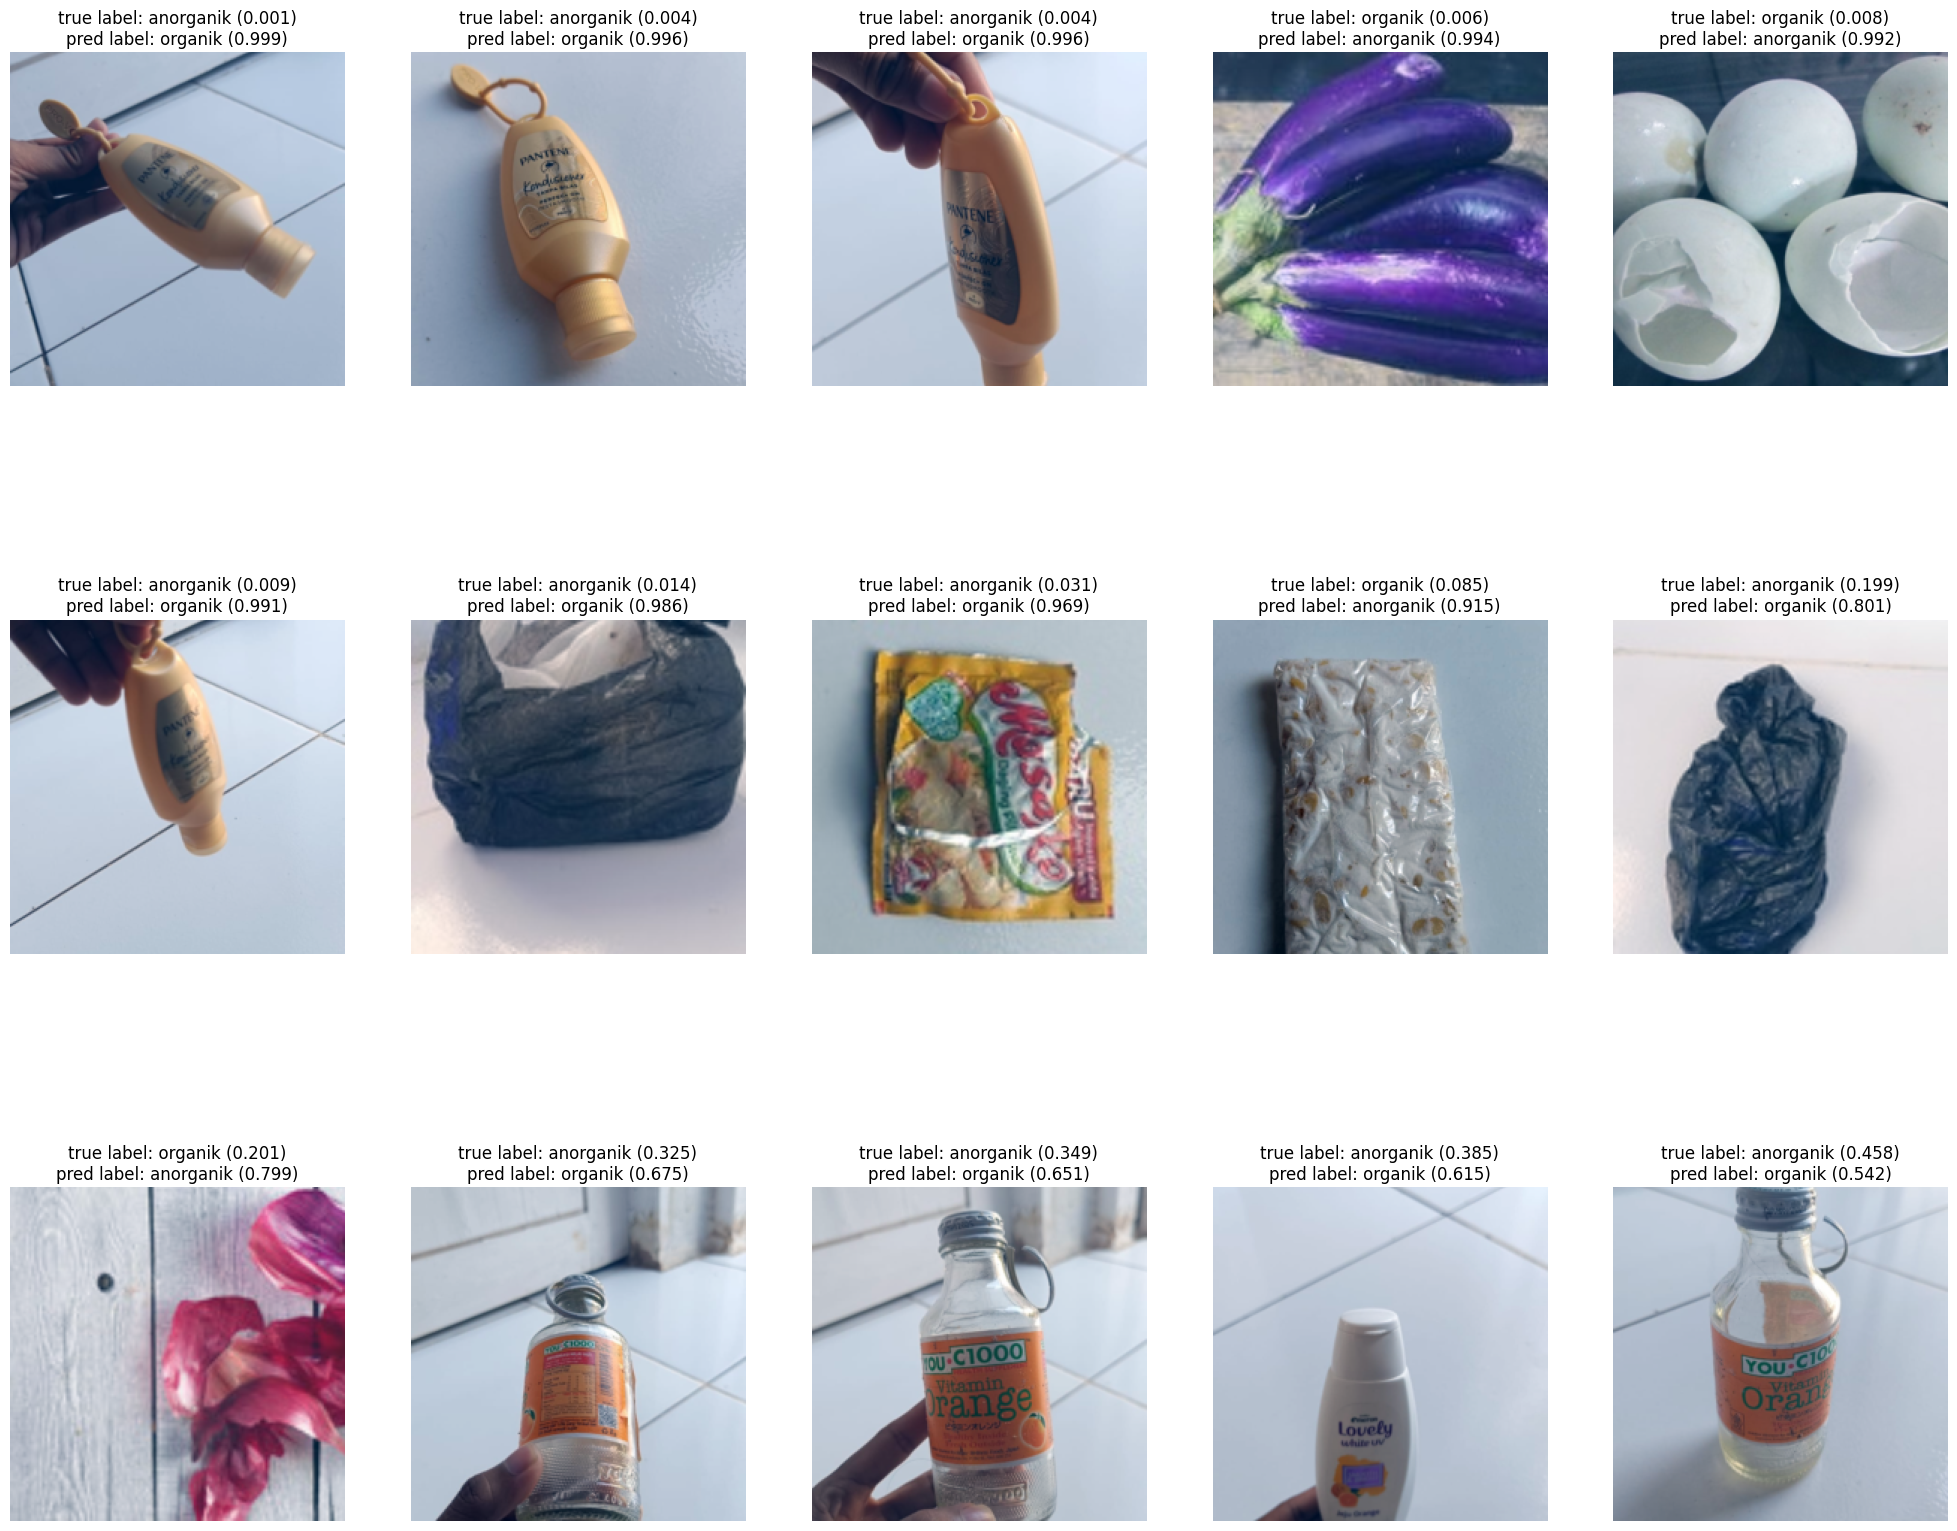

In [174]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)